In [1]:
from stravalib.client import Client
client = Client()
MY_STRAVA_CLIENT_ID, MY_STRAVA_CLIENT_SECRET = open('./client.secret').read().strip().split(',')
print ('Client ID and secret read from file'.format(MY_STRAVA_CLIENT_ID) )

Client ID and secret read from file


In [5]:
url = client.authorization_url(client_id=MY_STRAVA_CLIENT_ID, redirect_uri='http://127.0.0.1:5000/authorization', scope=['read_all','profile:read_all','activity:read_all'])

In [6]:
print(url)

https://www.strava.com/oauth/authorize?client_id=119392&redirect_uri=http%3A%2F%2F127.0.0.1%3A5000%2Fauthorization&approval_prompt=auto&scope=read_all%2Cprofile%3Aread_all%2Cactivity%3Aread_all&response_type=code


In [7]:
import pickle

CODE = 'b4b4d0f5c7213f954c82d59ebf3a3d78e9d4a0d7'
access_token = client.exchange_code_for_token(client_id=MY_STRAVA_CLIENT_ID, client_secret=MY_STRAVA_CLIENT_SECRET, code=CODE)
with open('../access_token.pickle', 'wb') as f:
    pickle.dump(access_token, f)

In [9]:
with open('../access_token.pickle', 'rb') as f:
    access_token = pickle.load(f)
    
print('Latest access token read from file:')
access_token

Latest access token read from file:


{'access_token': '5edf36ddb58a27183089fd8e99e02da00580b04f',
 'refresh_token': 'f2622dda62f9b76f31ed4d69a2d26ec02e229cc8',
 'expires_at': 1704546698}

In [24]:
import time
if time.time() > access_token['expires_at']:
    print('Token has expired, will refresh')
    refresh_response = client.refresh_access_token(client_id=MY_STRAVA_CLIENT_ID, client_secret=MY_STRAVA_CLIENT_SECRET, refresh_token=access_token['refresh_token'])
    access_token = refresh_response
    with open('../access_token.pickle', 'wb') as f:
        pickle.dump(refresh_response, f)
    print('Refreshed token saved to file')
    client.access_token = refresh_response['access_token']
    client.refresh_token = refresh_response['refresh_token']
    client.token_expires_at = refresh_response['expires_at']
        
else:
    print('Token still valid, expires at {}'
          .format(time.strftime("%a, %d %b %Y %H:%M:%S %Z", time.localtime(access_token['expires_at']))))
    client.access_token = access_token['access_token']
    client.refresh_token = access_token['refresh_token']
    client.token_expires_at = access_token['expires_at']

Token still valid, expires at Sat, 06 Jan 2024 18:41:38 India Standard Time


In [25]:
athlete = client.get_athlete()
print("Athlete's name is {} {}, based in {}, {}"
      .format(athlete.firstname, athlete.lastname, athlete.city, athlete.country))

Athlete's name is Alosh Denny, based in None, None


In [27]:
activities = client.get_activities(limit=1000)
list(activities)[0:10]

[]

In [28]:
my_cols =['name',
          'start_date_local',
          'type',
          'distance',
          'moving_time',
          'elapsed_time',
          'total_elevation_gain',
          'elev_high',
          'elev_low',
          'average_speed',
          'max_speed',
          'average_heartrate',
          'max_heartrate',
          'start_latlng']

In [29]:
data = []
for activity in activities:
    my_dict = activity.to_dict()
    data.append([activity.id]+[my_dict.get(x) for x in my_cols])
    
# Add id to the beginning of the columns, used when selecting a specific activity
my_cols.insert(0,'id')

In [38]:
import pandas as pd
df = pd.DataFrame(data, columns=my_cols)
# Make all walks into hikes for consistency
df['type'] = df['type'].replace('Walk','Hike')
# Create a distance in km column
df['distance_km'] = df['distance']/1e3
# Convert dates to datetime type
df['start_date_local'] = pd.to_datetime(df['start_date_local'])
# Create a day of the week and month of the year columns
df['day_of_week'] = df['start_date_local'].dt.day_name()
df['month_of_year'] = df['start_date_local'].dt.month
# Convert times to timedeltas
df['moving_time'] = pd.to_timedelta(df['moving_time'])
df['elapsed_time'] = pd.to_timedelta(df['elapsed_time'])
# Convert timings to hours for plotting
df['elapsed_time_hr'] = df['elapsed_time'].astype('int64')/3600e9
df['moving_time_hr'] = df['moving_time'].astype('int64')/3600e9

In [44]:
df.head()
print(df.columns)

Index(['id', 'name', 'start_date_local', 'type', 'distance', 'moving_time',
       'elapsed_time', 'total_elevation_gain', 'elev_high', 'elev_low',
       'average_speed', 'max_speed', 'average_heartrate', 'max_heartrate',
       'start_latlng', 'distance_km', 'day_of_week', 'month_of_year',
       'elapsed_time_hr', 'moving_time_hr'],
      dtype='object')


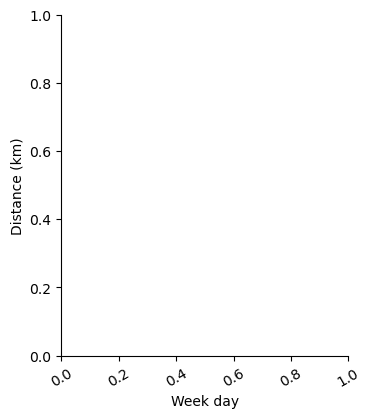

In [42]:
import seaborn as sns

day_of_week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday' ]
g = sns.catplot(x='day_of_week', y='distance_km', kind='strip', data=df, order=day_of_week_order, col='type', height=4, aspect=0.9, palette='pastel')
(g.set_axis_labels("Week day", "Distance (km)")
  .set_titles("Activity type: {col_name}")
  .set_xticklabels(rotation=30));

In [40]:
activity_number=0
types = ['time', 'distance', 'latlng', 'altitude', 'velocity_smooth', 'moving', 'grade_smooth']
activity_data=client.get_activity_streams(df['id'][activity_number], types=types)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [43]:
import folium

map = folium.Map(location=[df['start_latlng'][activity_number].split(',')[0],df['start_latlng'][activity_number].split(',')[1]],
                 zoom_start=14,
                 width='100%'
                )
folium.PolyLine(activity_data['latlng'].data).add_to(map)
map

IndexError: index 0 is out of bounds for axis 0 with size 0